Notebook originally taken from here:
[https://github.com/gdmarmerola/interactive-intro-rl/blob/master/notebooks/ts_for_multi_armed_bandit.ipynb](https://github.com/gdmarmerola/interactive-intro-rl/blob/master/notebooks/ts_for_multi_armed_bandit.ipynb)
and adjusted afterwards

In [232]:
# plotting inline
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import beta as beta_dist
from functools import partial
from tqdm import tqdm

In [ ]:
sns.set_theme(style="whitegrid")

In [ ]:
sns.set_theme(style="darkgrid")

In [ ]:
# class for our row of bandits
class Casino:

    # initialization
    def __init__(self, probabilities):

        # storing bandit probs
        self.probabilities = probabilities

    # function that helps us draw from the bandits
    def draw(self, k):

        # we return the reward and the regret of the action
        return np.random.binomial(1, self.probabilities[k]), np.max(self.probabilities) - self.probabilities[k]

In [411]:
bandit_probabilities = [ 0.7, 0.8, 0.3 ]

casino = Casino(bandit_probabilities)

In [ ]:
# let us create a function that returns the pdf for our beta posteriors
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

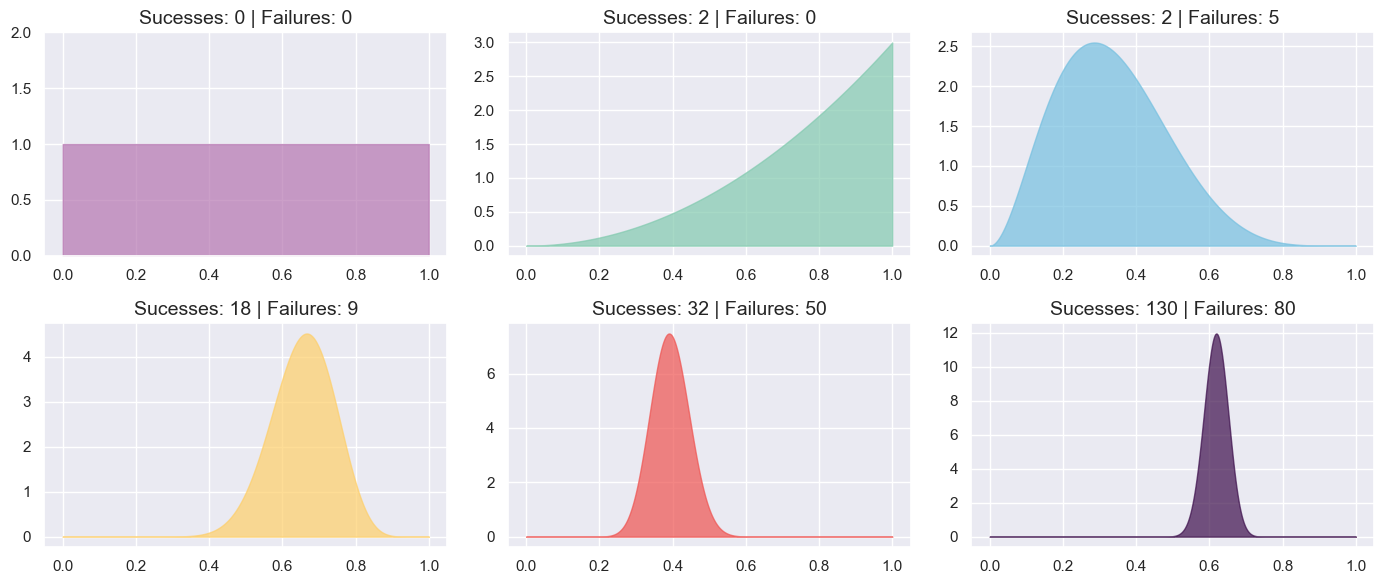

In [652]:
# examples for beta distribution

# examples
beta_examples = [(0,0),(2,0),(2,5),(18,9),(32,50),(130,80)]

# colors for the plots
colors = [ "#b676b1", "#82caaf", "#75c0e0", "#fecf6a", "#ef5350", "#3C0E4B" ]

# opening figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=100, nrows=2, ncols=3)


# loop for each
for i, example in enumerate(beta_examples):

    X, pdf = get_beta_pdf(example[0], example[1])

    #sns.lineplot(x=X, y=pdf, ax=ax[int(i/3)][(i % 3)])

    # plotly data
    ax[int(i/3)][(i % 3)].fill_between(X, 0, pdf, color=colors[i], alpha=0.7)
    ax[int(i/3)][(i % 3)].set_title('Sucesses: {} | Failures: {}'.format(example[0],example[1]), fontsize=14)


# some adjustments
ax[0][0].set(ylim=[0,2])
plt.tight_layout()

# showing the figure
#plt.show()


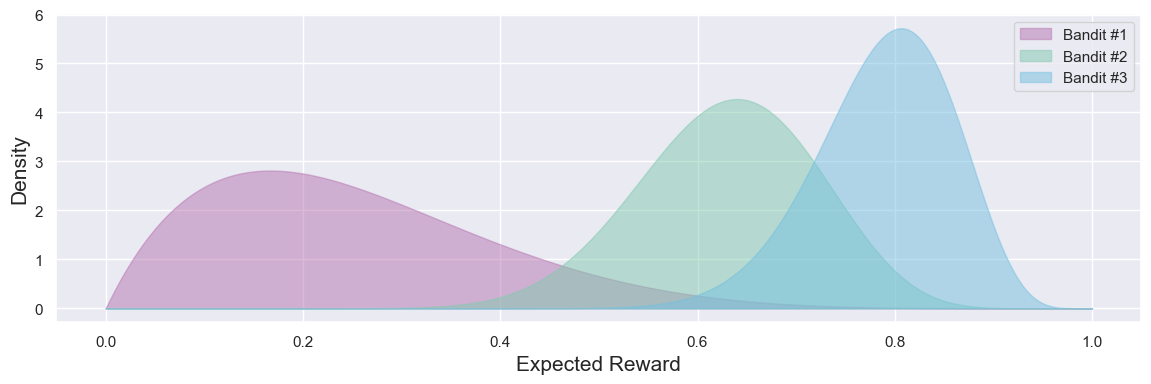

In [631]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
ax.set_xlabel('Expected Reward', fontsize=15)
ax.set_ylabel('Density', fontsize=15)

examples = [(1,5),(16,9),(25,6)]

for i, example in enumerate(examples):

    X, pdf = get_beta_pdf(example[0], example[1])

    ax.fill_between(X, 0, pdf, color=colors[i], alpha=0.5)

lg = ax.legend(labels=["Bandit #1", "Bandit #2", "Bandit #3"])


In [412]:
class Policy:
    def __init__(self, n_bandits = 3):
        self.n_bandits = n_bandits
        self.success_count = [0] * n_bandits
        self.failure_count = [0] * n_bandits
        self.choices = []
        self.rewards = []
        self.regrets = []

    def choose_bandit(self):
        return 0

    def update_with_result(self, choice, reward, regret):
        self.choices.append(choice)
        self.rewards.append(reward)
        self.regrets.append(regret)

        if reward > 0:
            self.success_count[choice] += 1
        else:
            self.failure_count[choice] += 1

    def get_results(self):
        # one-hot encode choices
        targets = np.array(self.choices).reshape(-1)
        one_hot_targets = np.eye(self.n_bandits)[targets]
        return one_hot_targets, np.array(self.rewards), np.array(self.regrets)



In [413]:
class RandomPolicy(Policy):
    def __init__(self, n_bandits = 3):
        super().__init__(n_bandits)

    def choose_bandit(self):
        return np.random.choice(range(self.n_bandits),1)[0]

In [567]:
# number of draws
N_DRAWS = 500

# number of bandits
N_BANDITS = len(casino.probabilities)

In [583]:

# let us wrap a function that draws the draws and distributions of the bandit experiment
def plot_MAB_experiment(policy: Policy, N_DRAWS, bandit_probs, plot_title):

    # number of bandits
    N_BANDITS = len(bandit_probs)

    color_array = colors[:N_BANDITS]

     # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=3)
    #ax2 = plt.subplot2grid((5, 3), (3, 0), rowspan=2)
    #ax3 = plt.subplot2grid((5, 3), (3, 1), rowspan=2)
    #ax4 = plt.subplot2grid((5, 3), (3, 2), rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        k = policy.choose_bandit()
        reward, regret = casino.draw(k)
        policy.update_with_result(k, reward, regret)

    # sucesses and failures for our beta distribution
    bandit_distributions = [None] * N_BANDITS

    # calculating pdfs for each bandit
    for bandit_id in range(N_BANDITS):

        X, pdf = get_beta_pdf(policy.success_count[bandit_id], policy.failure_count[bandit_id])

        # appending to posterior animation dict
        bandit_distributions[bandit_id]= {'X': X, 'curve': pdf}

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10)
    ax1.set_ylabel('Bandit', fontsize=10)
    ax1.set_yticks([0,1,2])
    ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(N_BANDITS)])
    ax1.tick_params(labelsize=10)

    # titles of distribution plots
    #ax2.set_title('Estimated $\\theta_0$', fontsize=10)
    #ax3.set_title('Estimated $\\theta_1$', fontsize=10)
    #ax4.set_title('Estimated $\\theta_2$', fontsize=10)

    marker_dict = {
        0: ".",
        1: "o"
    }

    sns.scatterplot(ax = ax1, y=policy.choices, x=list(range(N_DRAWS)), hue=policy.choices, palette=color_array, style=policy.rewards, markers=marker_dict, size=1, sizes=[60], legend=False)

    #dens1 = ax2.fill_between(bandit_distributions[0]["X"], 0, bandit_distributions[0]['curve'], color='red', alpha=0.7)
    #dens2 = ax3.fill_between(bandit_distributions[1]["X"], 0, bandit_distributions[1]['curve'], color='green', alpha=0.7)
    #dens3 = ax4.fill_between(bandit_distributions[2]["X"], 0, bandit_distributions[2]['curve'], color='blue', alpha=0.7)

    fig.tight_layout()



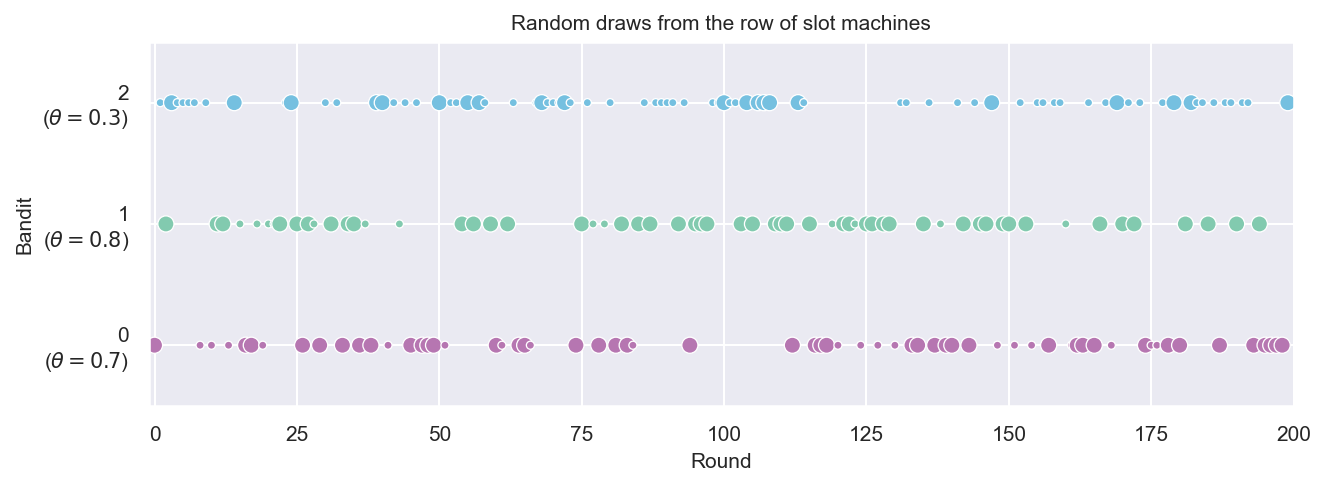

In [634]:
random_policy = RandomPolicy()

plot_MAB_experiment(random_policy, 200, casino.probabilities, 'Random draws from the row of slot machines')


In [364]:
# e-greedy policy

class EGreedyPolicy(Policy):

    # initializing
    def __init__(self, epsilon, init_prob=0.5, n_bandits=3, learn_rate=0.1, decay=1.0):
        super().__init__(n_bandits)
        self.epsilon = epsilon
        self.decay = decay
        self.learn_rate = learn_rate
        self.estimated_probabilities = [init_prob] * n_bandits

    # choice of bandit
    def choose_bandit(self):

        # choosing best greedy action or random depending with epsilon probability
        if np.random.random() < self.epsilon:

            return np.random.choice(list(range(N_BANDITS)))

            # returning random action, excluding best
            #return np.random.choice(np.delete(list(range(N_BANDITS)), np.argmax(self.estimated_probabilities)))

        # else return best
        else:
            probs = np.array(self.estimated_probabilities)
            # returning best greedy action
            return np.random.choice(np.flatnonzero(probs == probs.max()))
            #return np.argmax(self.estimated_probabilities)

    def update_with_result(self, choice, reward, regret):
        super().update_with_result(choice, reward, regret)
        self.estimated_probabilities[choice] = (1 - self.learn_rate) * self.estimated_probabilities[choice] + self.learn_rate * reward
        self.epsilon = self.epsilon * self.decay

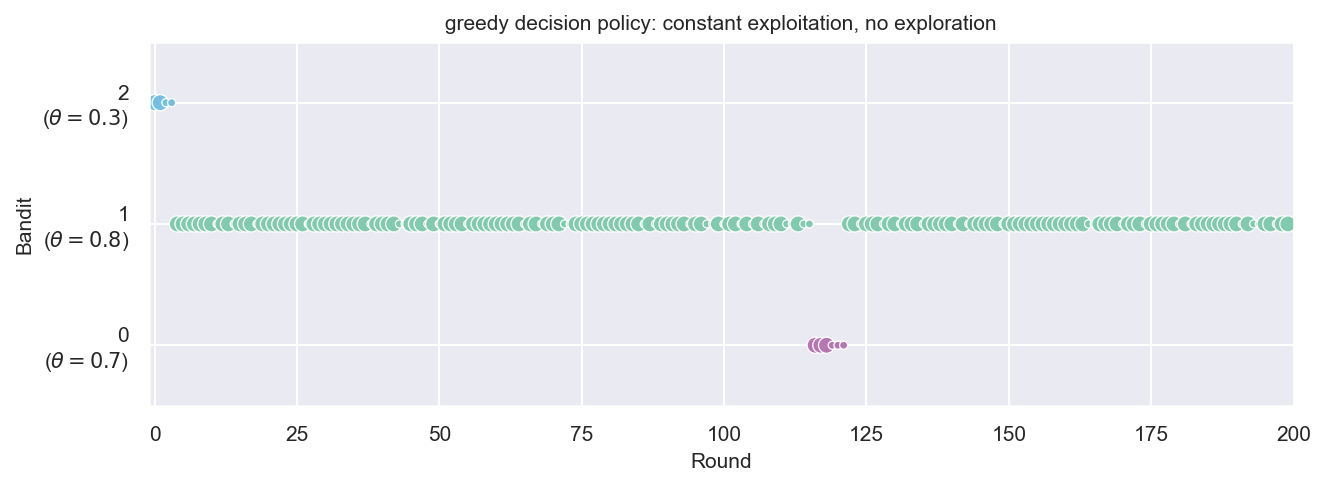

In [644]:
# greedy policy
greedy_policy = EGreedyPolicy(epsilon=0, init_prob=0.5)

plot_MAB_experiment(greedy_policy, 200, casino.probabilities, "greedy decision policy: constant exploitation, no exploration")

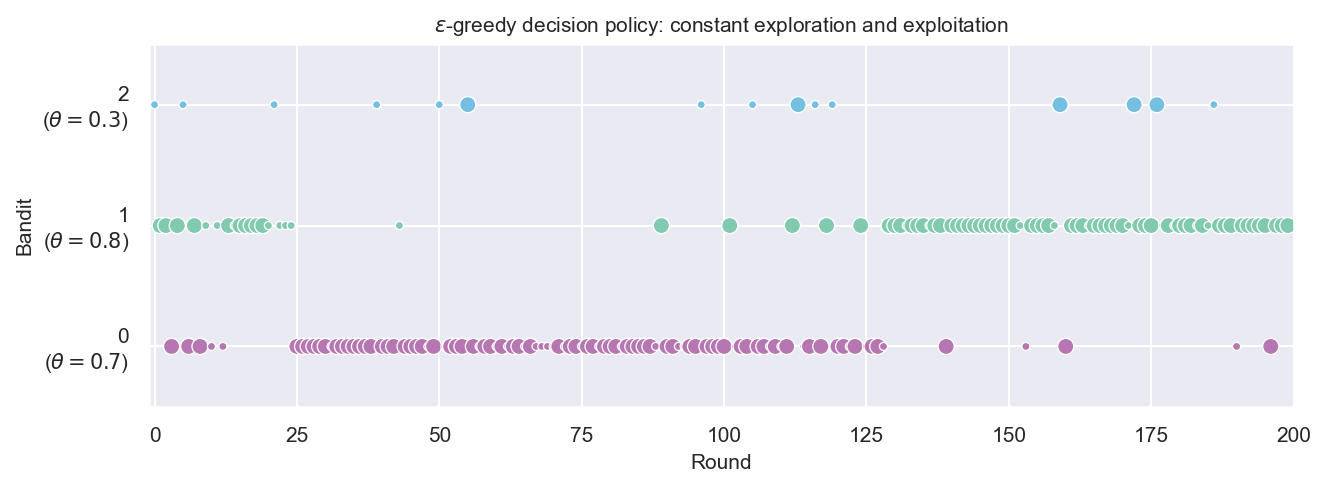

In [651]:
egreedy_policy = EGreedyPolicy(epsilon=0.2, learn_rate=0.1)

plot_MAB_experiment(egreedy_policy, 200, casino.probabilities, '$\epsilon$-greedy decision policy: constant exploration and exploitation')

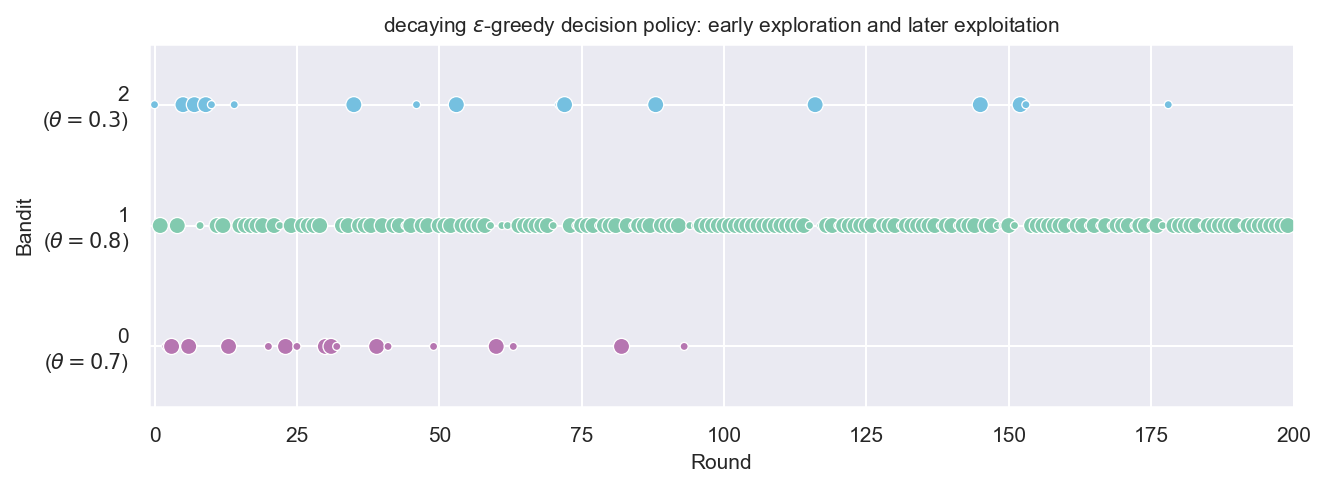

In [601]:
egreedy_decay_policy = EGreedyPolicy(epsilon=0.99, learn_rate=0.1, decay=0.97)

plot_MAB_experiment(egreedy_decay_policy, 200, casino.probabilities, 'decaying $\epsilon$-greedy decision policy: early exploration and later exploitation')

In [587]:
class TSPolicy(Policy):

    def __init__(self, n_bandits=3):

        super().__init__(n_bandits)
        self.success_count = [0] * n_bandits
        self.failure_count = [0] * n_bandits

    def choose_bandit(self):
        sample_list = [np.random.beta(1 + self.success_count[bandit_index], 1 + self.failure_count[bandit_index]) for bandit_index in range(self.n_bandits)]

        return np.argmax(sample_list)

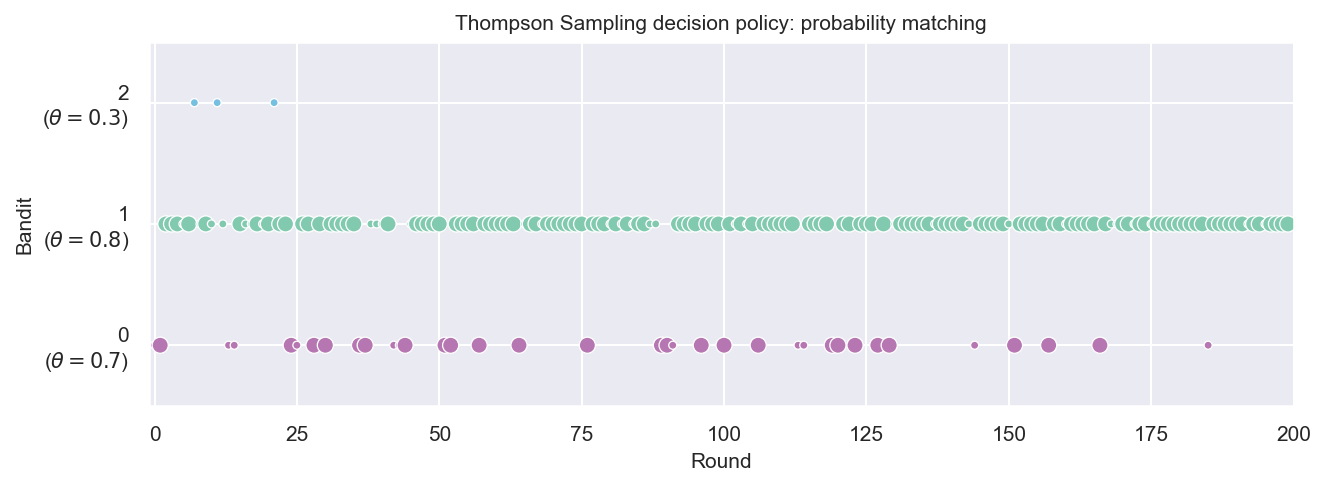

In [655]:
ts_policy = TSPolicy(n_bandits = 3)

plot_MAB_experiment(ts_policy, 200, casino.probabilities, 'Thompson Sampling decision policy: probability matching')

In [656]:
# Simulations

N_ROUNDS = 500
N_SIMULATIONS = 1000

In [668]:

# epsilon, init_prob=0.5, n_bandits=3, learn_rate=0.1, decay=1.0

policies = [
    { "policy": partial(TSPolicy, 3), "label": "Thompson Sampling" },
    { "policy": partial(EGreedyPolicy, 0.0 , 1.0, 3, 0.1, 1.0), "label": "optimistic init" },
    { "policy": partial(EGreedyPolicy, 0.05, 0.5, 3, 0.1, 1.0), "label": "e-greedy" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 0.90), "label": "decaying e-greedy" }
]

In [658]:
# e-greedy compared to greedy
policies = [
    { "policy": partial(EGreedyPolicy, 0.0 , 0.3, 3, 0.1, 1.0), "label": "greedy" },
    { "policy": partial(EGreedyPolicy, 0.05, 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.05" },
    { "policy": partial(EGreedyPolicy, 0.1 , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.1" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.2" }
]

In [660]:
# e-greedy

policies = [
    { "policy": partial(EGreedyPolicy, 0.025, 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.025" },
    { "policy": partial(EGreedyPolicy, 0.05 , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.05" },
    { "policy": partial(EGreedyPolicy, 0.1  , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.1" },
    { "policy": partial(EGreedyPolicy, 0.15 , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.15" },
    { "policy": partial(EGreedyPolicy, 0.2  , 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.2" }
]

In [664]:
# e-greedy decay
policies = [
    { "policy": partial(EGreedyPolicy, 0.05, 0.5, 3, 0.1, 1.0), "label": "epsilon = 0.05" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 0.995), "label": "decay = 0.995, e=0.2" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 0.99), "label": "decay = 0.99, e=0.2" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 0.95), "label": "decay = 0.95, e=0.2" },
    { "policy": partial(EGreedyPolicy, 0.2 , 0.5, 3, 0.1, 0.90), "label": "decay = 0.90, e=0.2" }
]

In [669]:
# run simulation

results = []

for policy_index in range(len(policies)):

    #print(policy_index)

    results.append({
        "choices": np.zeros((N_SIMULATIONS, N_ROUNDS, N_BANDITS)),
        "rewards": np.zeros((N_SIMULATIONS, N_ROUNDS)),
        "regrets": np.zeros((N_SIMULATIONS, N_ROUNDS))
    })

    for simulation_index in tqdm(range(N_SIMULATIONS)):

        policy: Policy = policies[policy_index]["policy"]()

        # loop generating draws
        for draw_number in range(N_ROUNDS):

            # record information about this draw
            choice = policy.choose_bandit()
            reward, regret = casino.draw(choice)
            policy.update_with_result(choice, reward, regret)

        sim_choices, sim_rewards, sim_regrets = policy.get_results()

        results[policy_index]["choices"][simulation_index] = sim_choices
        results[policy_index]["rewards"][simulation_index] = sim_rewards
        results[policy_index]["regrets"][simulation_index] = sim_regrets

    #results[policy_index]["choices"] /= N_SIMULATIONS
    #results[policy_index]["rewards"] /= N_SIMULATIONS
    #results[policy_index]["regrets"] /= N_SIMULATIONS

#results


100%|██████████| 1000/1000 [00:22<00:00, 43.83it/s]


In [ ]:
pd.DataFrame(results[0]["choices"].mean(axis=0))

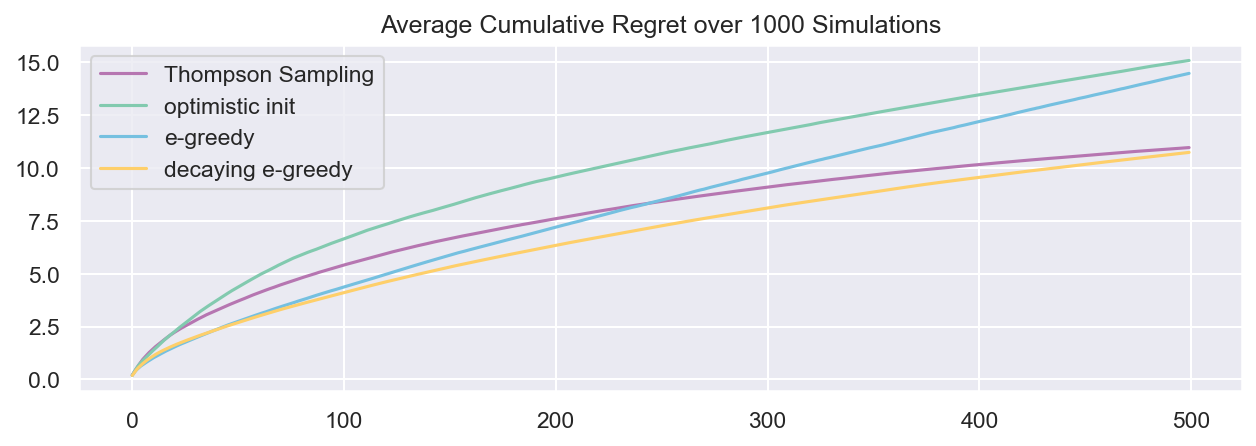

In [671]:
# cumulative regret
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)

for policy_index in range(len(results)):

    sum = np.mean(results[policy_index]["regrets"], axis = 0)
    cumsum = np.cumsum(sum)

    res = results[policy_index]["regrets"]

    #dataframe = pd.DataFrame(res)
    #dataframe = dataframe.sum(axis=0)
    #dataframe = dataframe.rolling(5).mean()
    #dataframe = pd.to_numeric(dataframe)

    #print(sum)

    sns.lineplot(x=range(N_ROUNDS), y=cumsum, ax=ax, color=colors[policy_index], errorbar=None)

    #sns.lineplot(data=dataframe, linewidth=1.25, color=colors[policy_index])

ax.set_title("Average Cumulative Regret over %s Simulations" % N_SIMULATIONS)
lg = ax.legend(labels=[policies[i]["label"] for i in range(len(results))])


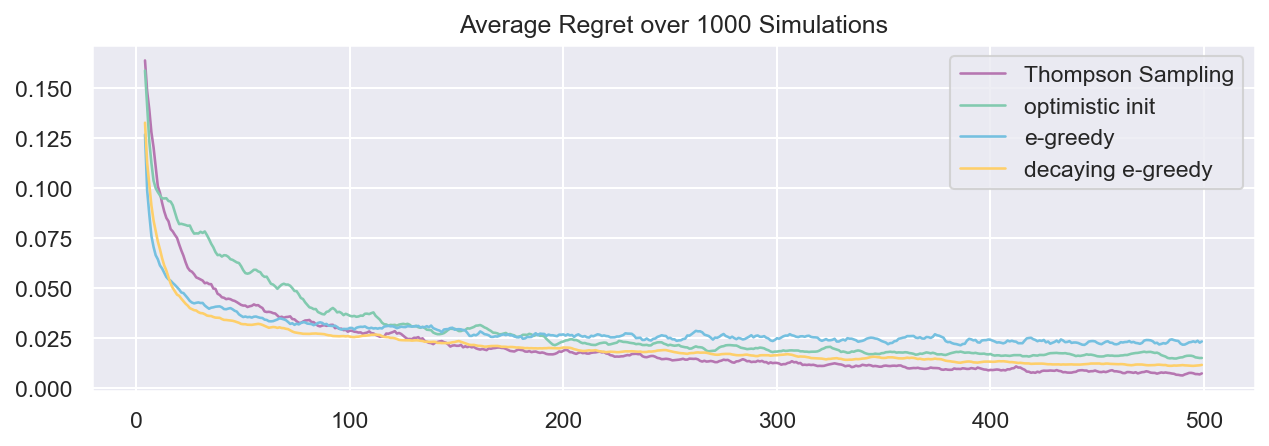

In [672]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)

for policy_index in range(len(results)):

    #sum = np.mean(results[policy_index]["regrets"]/N_SIMULATIONS, axis = 0)
    #cumsum = np.cumsum(sum)

    res = results[policy_index]["regrets"]

    dataframe = pd.DataFrame(res)
    dataframe = dataframe.mean(axis=0)
    dataframe = dataframe.rolling(5).mean()
    #dataframe = pd.to_numeric(dataframe)

    #print(sum)

    #sns.lineplot(x=range(N_ROUNDS), y=cumsum, ax=ax, color=colors[policy_index])

    sns.lineplot(data=dataframe, linewidth=1.25, color=colors[policy_index], errorbar=None)

ax.set_title("Average Regret over %s Simulations" % N_SIMULATIONS)
lg = ax.legend(labels=[policies[i]["label"] for i in range(len(results))])

In [ ]:
results[0]["rewards"]